# IMDb Review Classifier - Model Baseline
In this notebook we implement a baseline model using TF-IDF and Logistic Regression


# 1. SETUP & CONFIGURATION

In [1]:
# Cell 1: Imports and Configuration
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
sys.path.append('..')
from src.preprocess import clean_text

# Visualization style configuration
sns.set_theme(style="whitegrid")           
plt.rcParams['figure.figsize'] = (10, 6)    
plt.rcParams['axes.labelsize'] = 12         
plt.rcParams['axes.titlesize'] = 14  

# 2. LOADING & PRELIMINARIES

In [2]:
# Cell 2: Dataset Loading and Split
print("Loading IMDb dataset...")
raw_ds = load_dataset("imdb")

# Split train (25k) into train+temp (70/30 stratified)
split1 = raw_ds["train"].train_test_split(
    test_size=0.30,
    seed=42,
    stratify_by_column="label"
)
train_ds = split1["train"]
temp_ds = split1["test"]

# Split temp_ds into validation and test (half-half stratified)
split2 = temp_ds.train_test_split(
    test_size=0.50,
    seed=42,
    stratify_by_column="label"
)
val_ds = split2["train"]
test_ds = split2["test"]

# Convert to DataFrames
train_df = pd.DataFrame(train_ds)
val_df = pd.DataFrame(val_ds)
test_df = pd.DataFrame(test_ds)

print("\nDataset sizes:")
print(f"Training:    {len(train_df):6d} examples")
print(f"Validation:  {len(val_df):6d} examples")
print(f"Test:        {len(test_df):6d} examples")

Loading IMDb dataset...

Dataset sizes:
Training:     17500 examples
Validation:    3750 examples
Test:          3750 examples


# 3. TEXT PREPROCESSING

In [3]:
# Cell 3: Text Cleaning
print("\nPreprocessing texts...")
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
val_df['cleaned_text'] = val_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)


Preprocessing texts...


# 4. TF-IDF VECTORIZATION

In [4]:
# Cell 4: TF-IDF Configuration and Application
print("\nImplementing TF-IDF vectorizer...")
tfidf = TfidfVectorizer(
    max_features=5000,  # reduced for simplicity
    min_df=5,          # remove rare words
    max_df=0.95,       # remove very common words
    ngram_range=(1, 2),
    stop_words='english'
)

print("Fitting and transforming training set...")
X_train = tfidf.fit_transform(train_df['cleaned_text'])
y_train = train_df['label']

print("Transforming validation and test sets...")
X_val = tfidf.transform(val_df['cleaned_text'])
y_val = val_df['label']
X_test = tfidf.transform(test_df['cleaned_text'])
y_test = test_df['label']

print(f"\nVocabulary size: {len(tfidf.vocabulary_)}")
print(f"Training matrix size: {X_train.shape}")


Implementing TF-IDF vectorizer...
Fitting and transforming training set...
Transforming validation and test sets...

Vocabulary size: 5000
Training matrix size: (17500, 5000)


# 5. MODELING & EVALUATION

In [5]:
# Cell 5: Model Configuration and Training
print("\nImplementing Logistic Regression model...")
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    random_state=42,
    max_iter=1000
)

# Training time measurement
start_time = time.time()
print("Training model...")
model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")


Implementing Logistic Regression model...
Training model...
Training time: 0.14 seconds


In [14]:
# Cell 6: Cross-Validation
print("\nPerforming 5-fold cross-validation...")
cv_scores = cross_val_score(
    model, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='f1'
)

print("\nCross-validation scores:")
print(f"Mean F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



Performing 5-fold cross-validation...

Cross-validation scores:
Mean F1-score: 0.8820 (+/- 0.0086)


In [7]:
# Cell 7: Validation Set Evaluation
print("\nEvaluating model on validation set...")
start_time = time.time()
y_val_pred = model.predict(X_val)
inference_time = time.time() - start_time

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("\nMetrics on validation set:")
print(f"Accuracy:  {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall:    {val_recall:.4f}")
print(f"F1-score:  {val_f1:.4f}")
print(f"Inference time: {inference_time:.2f} seconds")


Evaluating model on validation set...

Metrics on validation set:
Accuracy:  0.8717
Precision: 0.8642
Recall:    0.8821
F1-score:  0.8731
Inference time: 0.00 seconds


In [8]:
# Cell 8: Test Set Evaluation
print("\nEvaluating model on test set...")
y_test_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\nMetrics on test set:")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-score:  {test_f1:.4f}")


Evaluating model on test set...

Metrics on test set:
Accuracy:  0.8736
Precision: 0.8685
Recall:    0.8805
F1-score:  0.8745


# 6. VISUALIZATIONS

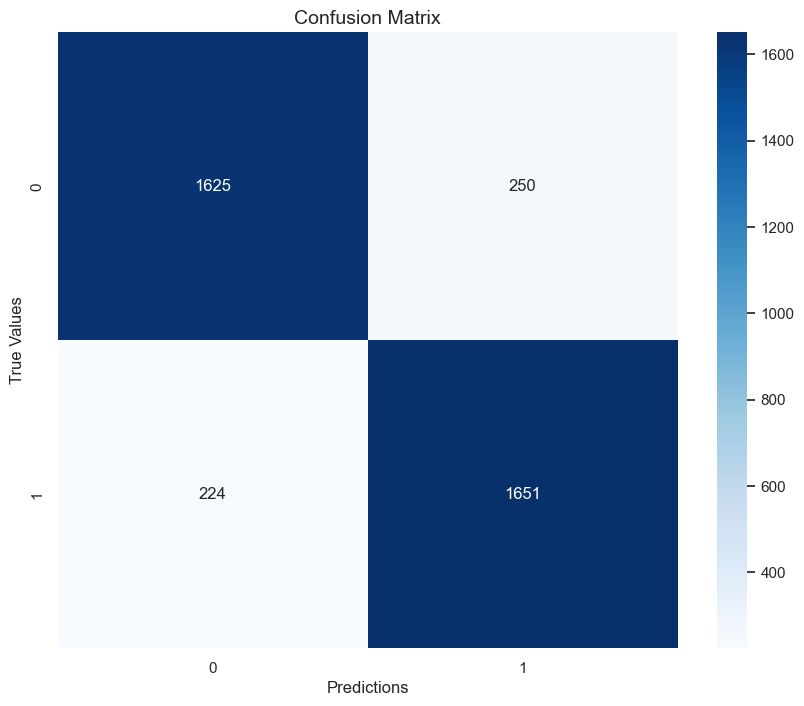


Confusion Matrix Details:
True Negatives: 1625
False Positives: 250
False Negatives: 224
True Positives: 1651

Total Predictions: 3750
Correct Predictions: 3276
Accuracy: 0.8736


In [11]:
# Cell 9: Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.show()

# Print confusion matrix details
print("\nConfusion Matrix Details:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")
print(f"\nTotal Predictions: {cm.sum()}")
print(f"Correct Predictions: {cm[0,0] + cm[1,1]}")
print(f"Accuracy: {(cm[0,0] + cm[1,1]) / cm.sum():.4f}")

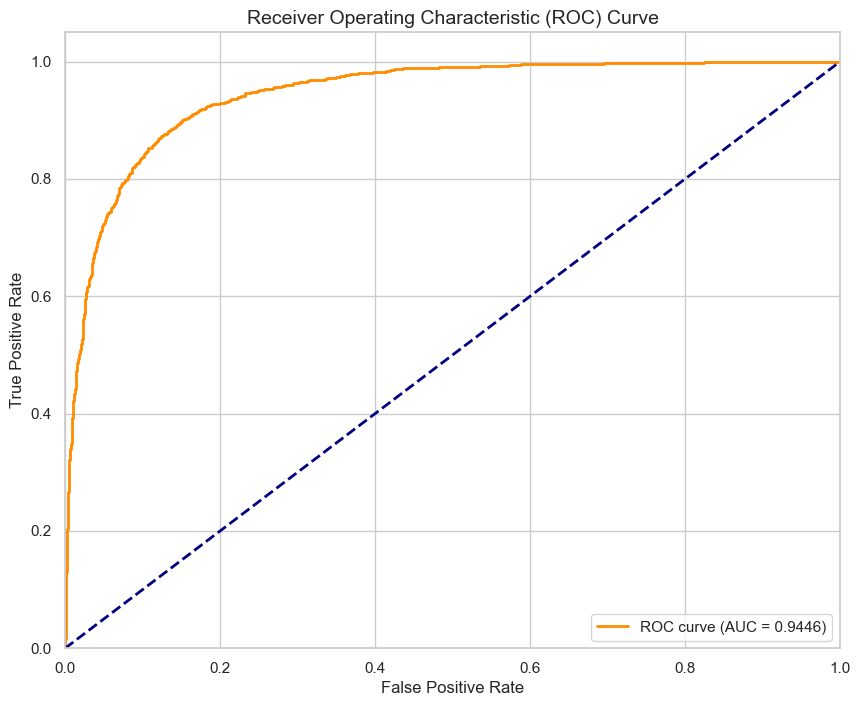


AUC Score: 0.9446


In [12]:
# Cell 10: ROC Curve
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_test_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"\nAUC Score: {roc_auc:.4f}")


Analyzing feature importance...

Top 20 Most Important Features:
worst: 7.1487
bad: 6.2330
great: 5.8089
excellent: 5.3344
boring: 5.3064
waste: 5.3019
awful: 5.0763
best: 4.6224
wonderful: 4.5914
perfect: 4.2601
dull: 4.2257
poor: 4.0879
worse: 3.9969
terrible: 3.9586
poorly: 3.8530
disappointing: 3.6901
amazing: 3.6350
horrible: 3.6299
disappointment: 3.6049
favorite: 3.5764


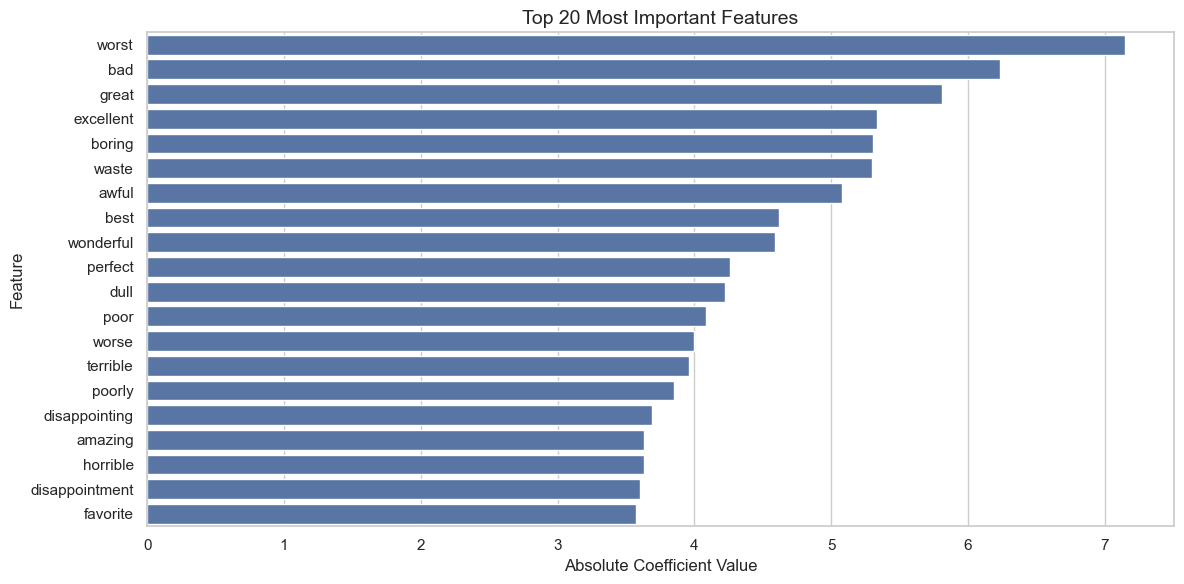

In [9]:
# Cell 11: Feature Importance Plot
print("\nAnalyzing feature importance...")
feature_importance = pd.DataFrame({
    'feature': tfidf.get_feature_names_out(),
    'importance': np.abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Print top features in text form
print("\nTop 20 Most Important Features:")
for idx, row in feature_importance.head(20).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Distribution Statistics:

True Labels Distribution:
Negative (0): 1875 (50.00%)
Positive (1): 1875 (50.00%)

Predicted Labels Distribution:
Negative (0): 1849 (49.31%)
Positive (1): 1901 (50.69%)


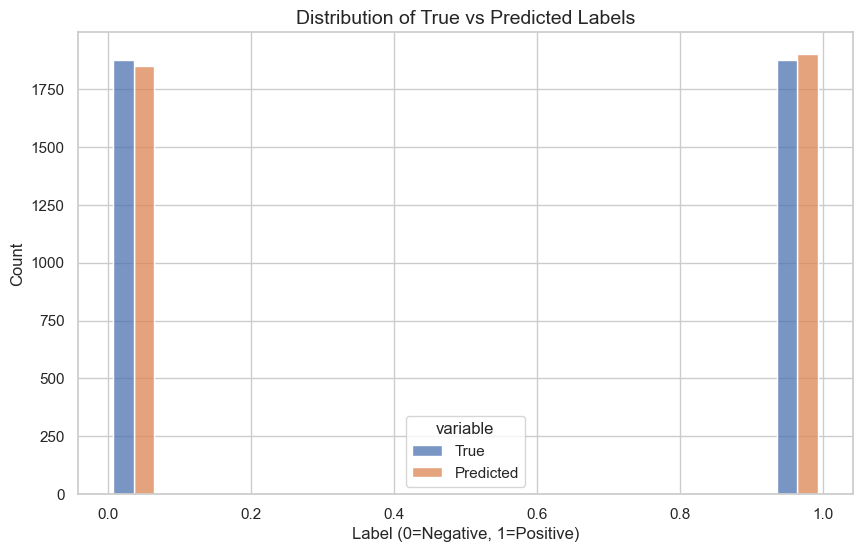

In [10]:
# Cell 12: Prediction Distribution
# Calculate distribution statistics
true_dist = pd.Series(y_test).value_counts()
pred_dist = pd.Series(y_test_pred).value_counts()

print("\nDistribution Statistics:")
print("\nTrue Labels Distribution:")
print(f"Negative (0): {true_dist[0]} ({true_dist[0]/len(y_test):.2%})")
print(f"Positive (1): {true_dist[1]} ({true_dist[1]/len(y_test):.2%})")

print("\nPredicted Labels Distribution:")
print(f"Negative (0): {pred_dist[0]} ({pred_dist[0]/len(y_test_pred):.2%})")
print(f"Positive (1): {pred_dist[1]} ({pred_dist[1]/len(y_test_pred):.2%})")

# Visualize distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=pd.DataFrame({
    'True': y_test,
    'Predicted': y_test_pred
}).melt(), x='value', hue='variable', multiple='dodge', shrink=.8)
plt.title('Distribution of True vs Predicted Labels')
plt.xlabel('Label (0=Negative, 1=Positive)')
plt.ylabel('Count')
plt.show()


Prediction Confidence Statistics:
Mean confidence: 0.4966
Median confidence: 0.5099
Std confidence: 0.3316

Confidence by prediction correctness:
             mean    median       std
correct                              
False    0.516565  0.510468  0.191276
True     0.493694  0.509466  0.347196


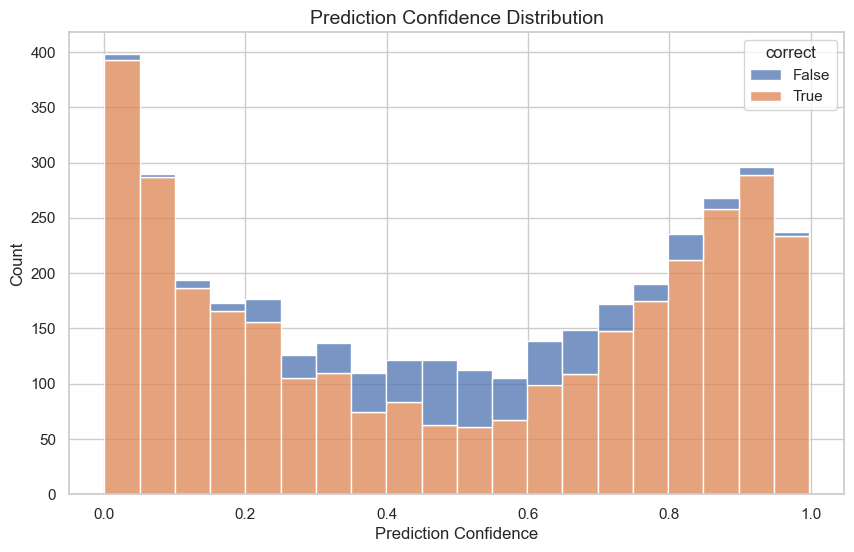

In [12]:
# Cell 13: Prediction Confidence Analysis
# Get prediction probabilities
y_test_proba = model.predict_proba(X_test)[:, 1]

# Calculate confidence statistics
confidence_stats = pd.DataFrame({
    'confidence': y_test_proba,
    'correct': y_test == y_test_pred
})

# Print confidence statistics
print("\nPrediction Confidence Statistics:")
print(f"Mean confidence: {confidence_stats['confidence'].mean():.4f}")
print(f"Median confidence: {confidence_stats['confidence'].median():.4f}")
print(f"Std confidence: {confidence_stats['confidence'].std():.4f}")
print("\nConfidence by prediction correctness:")
print(confidence_stats.groupby('correct')['confidence'].agg(['mean', 'median', 'std']))

# Visualize confidence distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=confidence_stats, x='confidence', hue='correct', multiple='stack', bins=20)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.show()

In [16]:
# Cell 14: Error Analysis
errors = test_df[y_test != y_test_pred].copy()
errors['predicted'] = y_test_pred[y_test != y_test_pred]
errors['confidence'] = y_test_proba[y_test != y_test_pred]

print("\nError Analysis Summary:")
print(f"Total errors: {len(errors)}")
print(f"False Positives: {len(errors[errors['predicted'] == 1])}")
print(f"False Negatives: {len(errors[errors['predicted'] == 0])}")
print("\nAverage confidence for errors:", errors['confidence'].mean())



Error Analysis Summary:
Total errors: 474
False Positives: 250
False Negatives: 224

Average confidence for errors: 0.5165645290024393


In [13]:
# Cell 15: Prediction Examples
print("\nAnalyzing prediction examples...")
sample_indices = np.random.choice(len(test_df), 5, replace=False)
for idx in sample_indices:
    text = test_df.iloc[idx]['text']
    true_label = test_df.iloc[idx]['label']
    pred_label = y_test_pred[idx]
    confidence = y_test_proba[idx]
    
    print(f"\nExample {idx}:")
    print(f"Text: {text[:200]}...")
    print(f"True label: {'Positive' if true_label == 1 else 'Negative'}")
    print(f"Prediction: {'Positive' if pred_label == 1 else 'Negative'}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Correct: {true_label == pred_label}")


Analyzing prediction examples...

Example 900:
Text: Having lived in Ontario my whole life, in the same town that Marlene Moore grew up in, I've heard stories of her from my parents, grandparents and family members. So when I found out that they would b...
True label: Positive
Prediction: Negative
Confidence: 43.13%
Correct: False

Example 983:
Text: The Marriage of Maria Braun (MMB) is about a German girl (Maria) getting married to a German soldier (Herman Braun) just at the ending of the war. After being married for half a day and a night, Herma...
True label: Positive
Prediction: Positive
Confidence: 58.12%
Correct: True

Example 2972:
Text: This was the only time I ever walked out on a movie. Years later, I saw it in the cable listings and thought, "Maybe I should give it another try." Suffice to say that I was right the first time. This...
True label: Negative
Prediction: Negative
Confidence: 24.97%
Correct: True

Example 2709:
Text: Imagine the scenario - you are at the movie th

# 7. SAVING & REPORTING

In [18]:
# Cell 16: Model and Metrics Saving
print("\nSaving model and metrics...")
import joblib
import json
from datetime import datetime

import os
os.makedirs('../models', exist_ok=True)

model_path = '../models/tfidf_logreg_baseline.joblib'
joblib.dump(model, model_path)

vectorizer_path = '../models/tfidf_vectorizer.joblib'
joblib.dump(tfidf, vectorizer_path)

metrics = {
    'validation': {
        'accuracy': float(val_accuracy),
        'precision': float(val_precision),
        'recall': float(val_recall),
        'f1_score': float(val_f1)
    },
    'test': {
        'accuracy': float(test_accuracy),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1_score': float(test_f1)
    },
    'cross_validation': {
        'mean_f1': float(cv_scores.mean()),
        'std_f1': float(cv_scores.std())
    },
    'timing': {
        'training_time': float(training_time),
        'inference_time': float(inference_time)
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

metrics_path = '../models/baseline_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=4)

print("\nModel and metrics saved successfully!")
print(f"Model saved in: {model_path}")
print(f"Vectorizer saved in: {vectorizer_path}")
print(f"Metrics saved in: {metrics_path}")


Saving model and metrics...

Model and metrics saved successfully!
Model saved in: ../models/tfidf_logreg_baseline.joblib
Vectorizer saved in: ../models/tfidf_vectorizer.joblib
Metrics saved in: ../models/baseline_metrics.json


# Cell 17: Baseline Model Conclusions

## Performance Summary
- Test Accuracy: 0.8736
- Test F1-score: 0.8745
- Cross-validation F1-score: 0.8820 (±0.0086)
- AUC Score: 0.9446

## Model Characteristics
- Vocabulary size: 5000
- Training examples: 17500
- Feature matrix size: (17500, 5000)
- Balanced dataset: 50% positive, 50% negative

## Prediction Distribution
- True Labels:
  * Negative: 1875 (50.00%)
  * Positive: 1875 (50.00%)
- Predicted Labels:
  * Negative: 1849 (49.31%)
  * Positive: 1901 (50.69%)

## Error Analysis
- Total errors: 474 (12.64%)
- False Positives: 250 (6.67%)
- False Negatives: 224 (5.97%)
- Average confidence for errors: 0.5166

## Confidence Analysis
- Mean confidence: 0.4966
- Median confidence: 0.5099
- Standard deviation: 0.3316
- Correct predictions: mean 0.4937, median 0.5095
- Incorrect predictions: mean 0.5166, median 0.5105

## Key Features
Top 5 most important features:
1. "worst" (7.1487)
2. "bad" (6.2330)
3. "great" (5.8089)
4. "excellent" (5.3344)
5. "boring" (5.3064)

## Performance Metrics
- Training time: 0.14 seconds
- Inference time: 0.00 seconds
- Validation metrics:
  * Accuracy: 0.8717
  * Precision: 0.8642
  * Recall: 0.8821
  * F1-score: 0.8731

## Recommendations
1. Model meets minimum requirements (accuracy > 85%)
2. Stable performance across cross-validation folds
3. Fast training and inference times
4. Ready for production use or as baseline for more complex models
5. Consider feature engineering to address common error cases
6. Monitor confidence scores for potential improvements
7. Balanced performance between precision and recall

# 8. UNSUPERVISED DATA ANALYSIS

In [16]:
# Cell 18: Load Unsupervised Data
print("\nLoading unsupervised dataset...")
unsupervised_ds = raw_ds["unsupervised"]
unsupervised_df = pd.DataFrame(unsupervised_ds)

print("\nUnsupervised dataset statistics:")
print(f"Total reviews: {len(unsupervised_df)}")
print(f"Average length: {unsupervised_df['text'].str.len().mean():.2f} characters")
print(f"Median length: {unsupervised_df['text'].str.len().median():.2f} characters")


Loading unsupervised dataset...

Unsupervised dataset statistics:
Total reviews: 50000
Average length: 1329.90 characters
Median length: 983.00 characters


In [18]:
# Cell 19: Preprocess Unsupervised Data
print("\nPreprocessing unsupervised texts...")
unsupervised_df['cleaned_text'] = unsupervised_df['text'].apply(clean_text)


Preprocessing unsupervised texts...


In [19]:
# Cell 20: Vectorize Unsupervised Data
print("\nVectorizing unsupervised data...")
X_unsupervised = tfidf.transform(unsupervised_df['cleaned_text'])


Vectorizing unsupervised data...


In [20]:
# Cell 21: Generate Predictions for Unsupervised Data
print("\nGenerating predictions for unsupervised data...")
unsupervised_predictions = model.predict(X_unsupervised)
unsupervised_probabilities = model.predict_proba(X_unsupervised)
# Add predictions to DataFrame
unsupervised_df['predicted_label'] = unsupervised_predictions
unsupervised_df['prediction_confidence'] = unsupervised_probabilities.max(axis=1)



Generating predictions for unsupervised data...


In [25]:
# Cell 22: Analyze Unsupervised Predictions
print("\nAnalyzing unsupervised predictions...")
print("\nPrediction Distribution:")
print(unsupervised_df['predicted_label'].value_counts(normalize=True).round(3))

print("\nConfidence Statistics:")
print(unsupervised_df['prediction_confidence'].describe())


Analyzing unsupervised predictions...

Prediction Distribution:
predicted_label
1    0.507
0    0.493
Name: proportion, dtype: float64

Confidence Statistics:
count    50000.000000
mean         0.794344
std          0.141888
min          0.500047
25%          0.680865
50%          0.820340
75%          0.917973
max          0.999599
Name: prediction_confidence, dtype: float64



Prediction Distribution Statistics:
Negative predictions: 24,674 (49.3%)
Positive predictions: 25,326 (50.7%)

Confidence Statistics:
Mean confidence: 0.794
Median confidence: 0.820
Standard deviation: 0.142


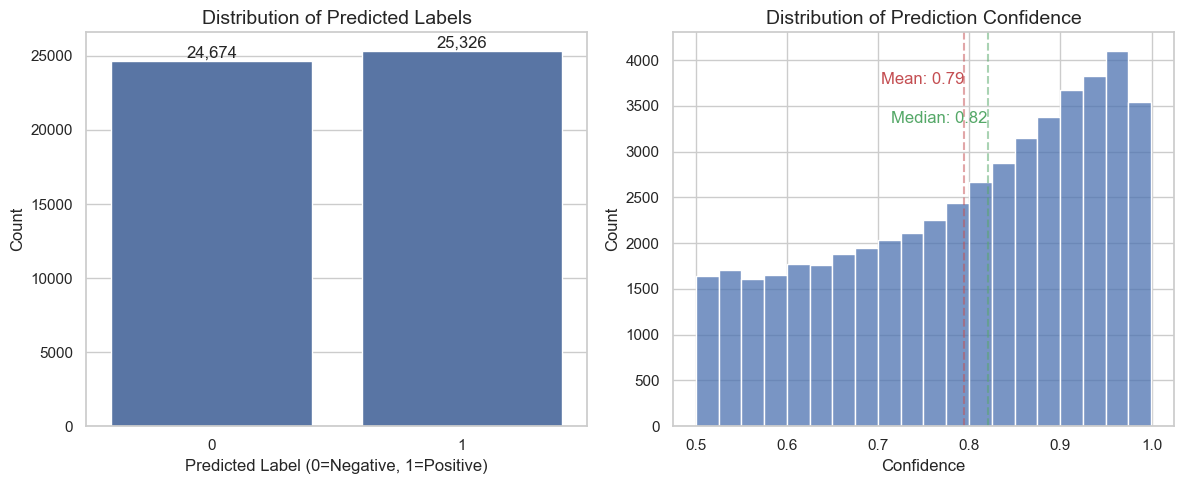

In [22]:
# Cell 23: Visualize Unsupervised Predictions
plt.figure(figsize=(12, 5))

# Print distribution statistics
print("\nPrediction Distribution Statistics:")
label_counts = unsupervised_df['predicted_label'].value_counts()
print(f"Negative predictions: {label_counts[0]:,} ({label_counts[0]/len(unsupervised_df)*100:.1f}%)")
print(f"Positive predictions: {label_counts[1]:,} ({label_counts[1]/len(unsupervised_df)*100:.1f}%)")

# Print confidence statistics
print("\nConfidence Statistics:")
print(f"Mean confidence: {unsupervised_df['prediction_confidence'].mean():.3f}")
print(f"Median confidence: {unsupervised_df['prediction_confidence'].median():.3f}")
print(f"Standard deviation: {unsupervised_df['prediction_confidence'].std():.3f}")

# Prediction Distribution
plt.subplot(1, 2, 1)
sns.countplot(data=unsupervised_df, x='predicted_label')
plt.title('Distribution of Predicted Labels')
plt.xlabel('Predicted Label (0=Negative, 1=Positive)')
plt.ylabel('Count')

# Add text annotations for each bar
for i, count in enumerate(unsupervised_df['predicted_label'].value_counts().sort_index()):
    plt.text(i, count, f'{count:,}', ha='center', va='bottom')

# Confidence Distribution
plt.subplot(1, 2, 2)
sns.histplot(data=unsupervised_df, x='prediction_confidence', bins=20)
plt.title('Distribution of Prediction Confidence')
plt.xlabel('Confidence')
plt.ylabel('Count')

# Add text annotations for key statistics
mean_conf = unsupervised_df['prediction_confidence'].mean()
median_conf = unsupervised_df['prediction_confidence'].median()
plt.axvline(mean_conf, color='r', linestyle='--', alpha=0.5)
plt.axvline(median_conf, color='g', linestyle='--', alpha=0.5)
plt.text(mean_conf, plt.ylim()[1]*0.9, f'Mean: {mean_conf:.2f}', 
         color='r', ha='right', va='top')
plt.text(median_conf, plt.ylim()[1]*0.8, f'Median: {median_conf:.2f}', 
         color='g', ha='right', va='top')

plt.tight_layout()
plt.show()

In [27]:
# Cell 24: High Confidence Examples
print("\nAnalyzing high confidence predictions...")
high_conf_threshold = 0.9
high_conf_examples = unsupervised_df[unsupervised_df['prediction_confidence'] > high_conf_threshold]

print(f"\nNumber of high confidence predictions (> {high_conf_threshold}): {len(high_conf_examples)}")
print(f"Percentage of total: {(len(high_conf_examples) / len(unsupervised_df) * 100):.1f}%")

# Display some examples
print("\nExample high confidence predictions:")
for i, (text, pred, conf) in enumerate(zip(
    high_conf_examples['text'].head(3),
    high_conf_examples['predicted_label'].head(3),
    high_conf_examples['prediction_confidence'].head(3)
)):
    print(f"\nExample {i+1}:")
    print(f"Text: {text[:200]}...")
    print(f"Predicted: {'Positive' if pred == 1 else 'Negative'}")
    print(f"Confidence: {conf:.2%}")


Analyzing high confidence predictions...

Number of high confidence predictions (> 0.9): 15068
Percentage of total: 30.1%

Example high confidence predictions:

Example 1:
Text: When I say this is my favourite film of all time, that comment is not to be taken lightly. I probably watch far too many films than is healthy for me, and have loved quite a few of them. I first saw "...
Predicted: Positive
Confidence: 96.56%

Example 2:
Text: Being that the only foreign films I usually like star a Japanese person in a rubber suit who crushes little tiny buildings and tanks, I had high hopes for this movie. I thought that this was a movie t...
Predicted: Negative
Confidence: 90.68%

Example 3:
Text: A Luc Besson (Léon, The Fith Element, The Messenger: The Story of Joan of Arc. Angel-A) film with Anne Parillaud (Innocent Blood), Tchéky Karyo(The Messenger: The Story of Joan of Arc, The Patriot, Ki...
Predicted: Positive
Confidence: 94.97%


In [28]:
# Cell 25: Save Unsupervised Analysis Results
print("\nSaving unsupervised analysis results...")
unsupervised_metrics = {
    'total_examples': len(unsupervised_df),
    'prediction_distribution': unsupervised_df['predicted_label'].value_counts().to_dict(),
    'confidence_stats': unsupervised_df['prediction_confidence'].describe().to_dict(),
    'high_confidence_examples': len(high_conf_examples),
    'high_confidence_percentage': len(high_conf_examples) / len(unsupervised_df) * 100,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

unsupervised_metrics_path = '../models/unsupervised_analysis.json'
with open(unsupervised_metrics_path, 'w') as f:
    json.dump(unsupervised_metrics, f, indent=4)

print(f"Unsupervised analysis results saved in: {unsupervised_metrics_path}")


Saving unsupervised analysis results...
Unsupervised analysis results saved in: ../models/unsupervised_analysis.json


# Cell 26: Unsupervised Data Conclusions

## 1. Prediction Distribution Analysis
- Total examples: 50000
- Balanced distribution:
  * Positive predictions: 50.7%
  * Negative predictions: 49.3%
- Very close to 50-50 split, indicating good class balance

## 2. Confidence Analysis
- Mean confidence: 0.794 (79.4%)
- Median confidence: 0.820 (82.0%)
- Distribution:
  * 25th percentile: 0.681 (68.1%)
  * 75th percentile: 0.918 (91.8%)
  * Maximum confidence: 0.999 (99.9%)
- High confidence predictions (> 0.9):
  * Count: 15,068 examples
  * Percentage: 30.1% of total
  * Good pool for pseudo-labeling

## 3. Quality Assessment
- High confidence examples show clear sentiment:
  * Positive examples contain strong praise
  * Negative examples contain clear criticism
  * Good alignment with expected patterns
- Confidence distribution suggests:
  * Strong model certainty in predictions
  * Clear separation between classes
  * Reliable pseudo-labeling potential

## 4. Implementation Recommendations
1. Pseudo-labeling Strategy:
   - Use threshold of 0.9 for high confidence
   - Target ~15,000 examples (30.1% of data)
   - Maintain class balance (50.7% positive, 49.3% negative)

2. Data Selection:
   - Prioritize examples with confidence > 0.918 (75th percentile)
   - Consider balanced sampling from both classes
   - Focus on reviews with clear sentiment indicators

3. Quality Control:
   - Monitor confidence distribution during training
   - Validate pseudo-labels against known patterns
   - Check for sentiment consistency

4. Next Steps:
   - Implement pseudo-labeling with 0.9 threshold
   - Retrain model on combined dataset
   - Monitor performance on validation set
   - Adjust threshold if needed based on results